In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob

In [ ]:
# Load the data
df = pd.read_csv('airindia_review.csv')

# Data Cleaning
df.drop_duplicates(inplace=True)
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')

<ipython-input-2-038c678e6024>:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')


<Axes: xlabel='rating', ylabel='Count'>

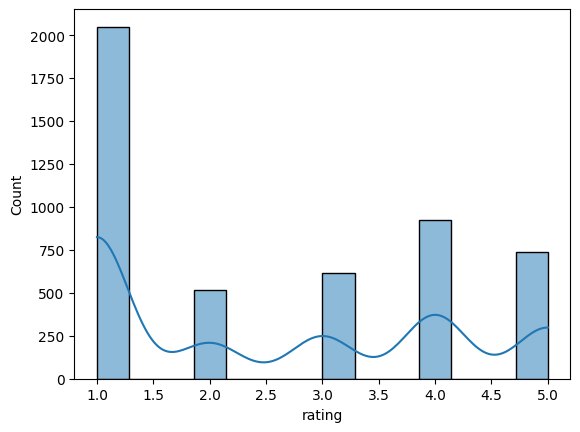

In [ ]:
# Descriptive Analysis
df.describe()

# Distribution Plots
sns.histplot(df['rating'], kde=True)

<Axes: xlabel='helpful_votes', ylabel='Count'>

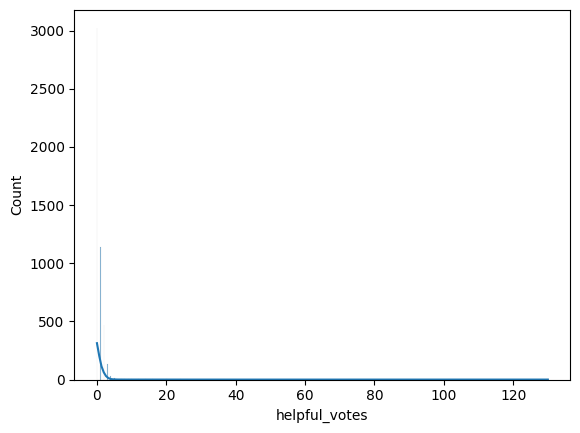

In [ ]:
sns.histplot(df['helpful_votes'], kde=True)

In [ ]:
# Sentiment Analysis
def get_sentiment(text):
    if pd.isnull(text):
        return 'neutral'
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['review_text'].apply(get_sentiment)
sentiment_counts = df['sentiment'].value_counts()


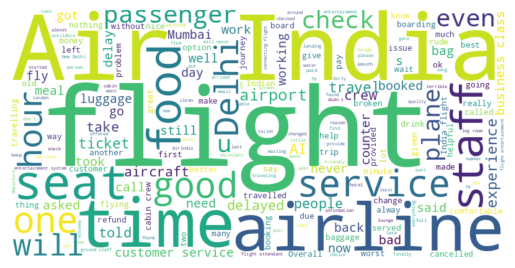

In [ ]:
# Word Cloud for Review Text
text = ' '.join(df['review_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

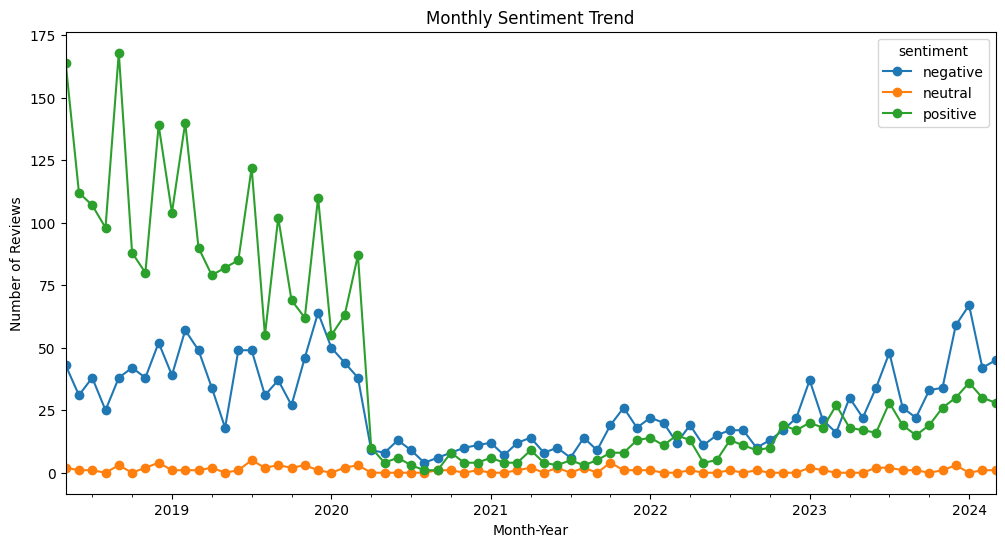

In [ ]:
# Extract month and year from the date
df['month_year'] = df['published_date'].dt.to_period('M')

# Group by month-year and calculate sentiment counts
monthly_sentiment = df.groupby(['month_year', 'sentiment']).size().unstack().fillna(0)

# Plot the sentiment trends
monthly_sentiment.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Monthly Sentiment Trend')
plt.xlabel('Month-Year')
plt.ylabel('Number of Reviews')
plt.show()

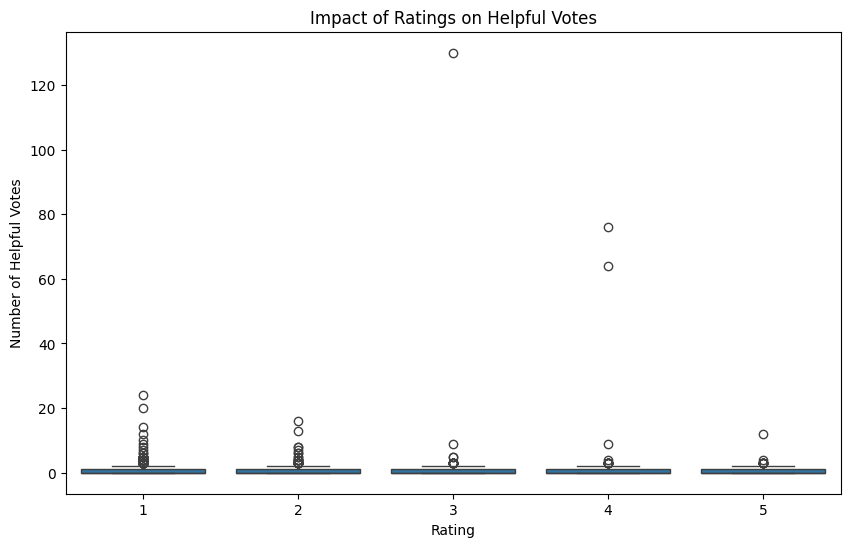

In [ ]:
# Boxplot for Rating vs. Helpful Votes
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='helpful_votes', data=df)
plt.title('Impact of Ratings on Helpful Votes')
plt.xlabel('Rating')
plt.ylabel('Number of Helpful Votes')
plt.show()

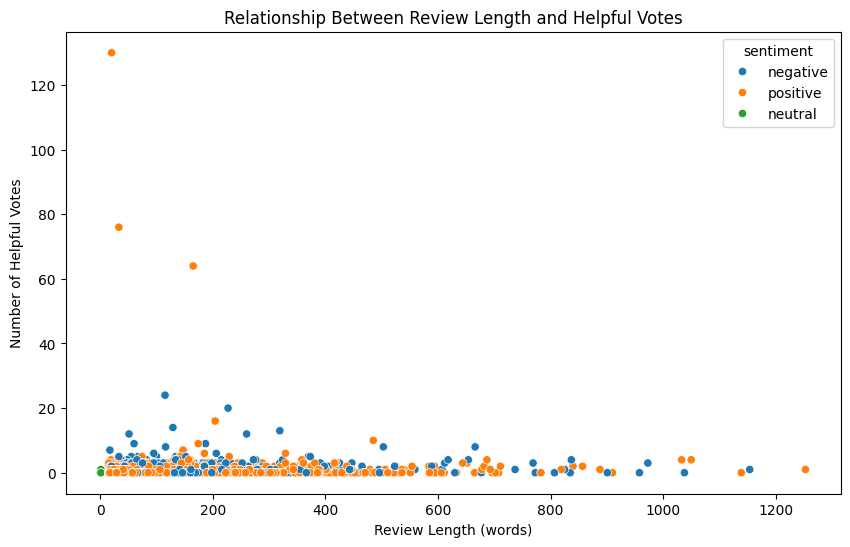

In [ ]:
# Create a column for review length (word count)
df['review_length'] = df['review_text'].apply(lambda x: len(str(x).split()))

# Scatter plot for review length vs. helpful votes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='helpful_votes', hue='sentiment', data=df)
plt.title('Relationship Between Review Length and Helpful Votes')
plt.xlabel('Review Length (words)')
plt.ylabel('Number of Helpful Votes')
plt.show()

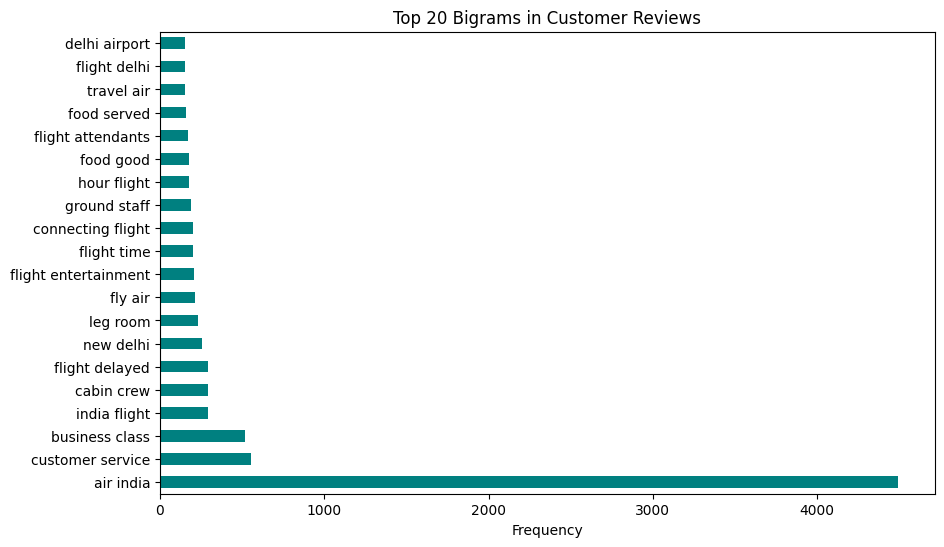

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract Bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigram_data = bigram_vectorizer.fit_transform(df['review_text'])

# Sum up occurrences of each bigram
bigram_counts = pd.DataFrame(bigram_data.sum(axis=0), columns=bigram_vectorizer.get_feature_names_out())
bigram_counts = bigram_counts.T.sort_values(by=0, ascending=False).head(20)

# Plot the most common bigrams
plt.figure(figsize=(10, 6))
bigram_counts[0].plot(kind='barh', color='teal')
plt.title('Top 20 Bigrams in Customer Reviews')
plt.xlabel('Frequency')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(df['review_text']).toarray()
y = df['sentiment']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Test the model
y_pred = rf_model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

    negative       0.78      0.78      0.78       588
     neutral       0.50      0.14      0.22        21
    positive       0.83      0.85      0.84       843

    accuracy                           0.81      1452
   macro avg       0.70      0.59      0.61      1452
weighted avg       0.81      0.81      0.81      1452



In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Extract words from review text
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['review_text'])

# Fit LDA with 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

# Print top 10 words in each topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda_model.components_):
    top_words = [words[index] for index in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {top_words}")

Topic 1: ['delayed', 'airport', 'service', 'customer', 'time', 'delhi', 'hours', 'air', 'india', 'flight']
Topic 2: ['crew', 'delhi', 'experience', 'service', 'time', 'food', 'air', 'india', 'good', 'flight']
Topic 3: ['staff', 'like', 'bad', 'don', 'worst', 'airline', 'flight', 'service', 'india', 'air']
Topic 4: ['crew', 'did', 'plane', 'business', 'entertainment', 'class', 'food', 'seats', 'seat', 'flight']
Topic 5: ['bag', 'flight', 'boarding', 'luggage', 'airport', 'india', 'baggage', 'air', 'staff', 'check']


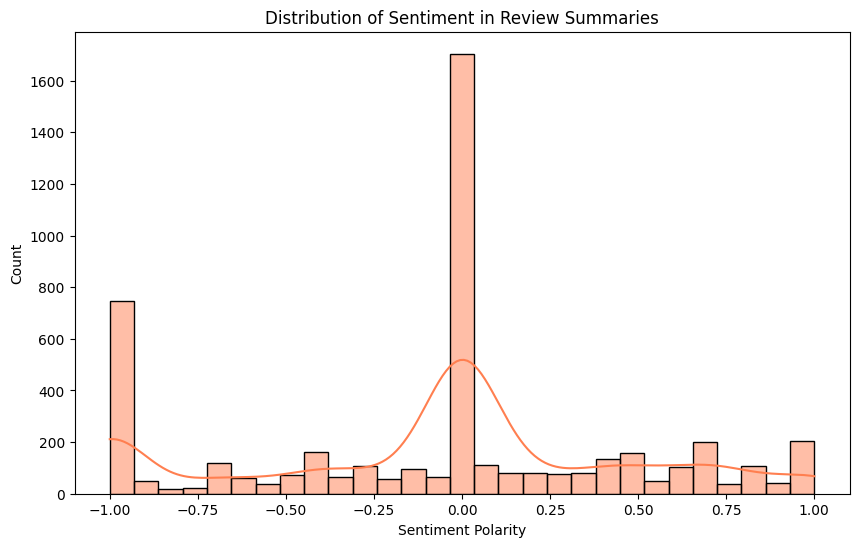

In [ ]:
df['summary_sentiment'] = df['review_summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.histplot(df['summary_sentiment'], kde=True, color='coral')
plt.title('Distribution of Sentiment in Review Summaries')
plt.xlabel('Sentiment Polarity')
plt.show()

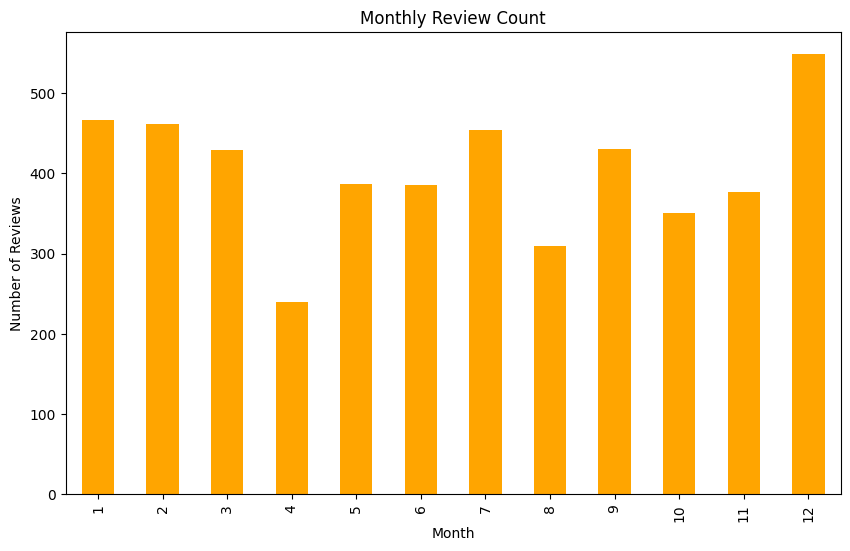

In [ ]:
# Extract the month from the published date
df['month'] = pd.to_datetime(df['published_date']).dt.month

# Count reviews by month
monthly_reviews = df.groupby('month').size()

# Plot review count by month
monthly_reviews.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Monthly Review Count')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

In [ ]:
# Classify customers as promoters, passives, and detractors
df['nps_category'] = df['rating'].apply(lambda x: 'Promoter' if x >= 4 else 'Passive' if x >= 3 else 'Detractor')

# Calculate NPS
nps_score = (df['nps_category'].value_counts(normalize=True)['Promoter'] - df['nps_category'].value_counts(normalize=True)['Detractor']) * 100
print(f'Net Promoter Score (NPS): {nps_score:.2f}')

Net Promoter Score (NPS): -18.66
